<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>SGDClassifier</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Классификация комментариев

Для классификации комментариев интернет-магазина необходимо создать модель, которая будет искать токсичные комментарии и отправлять их на модерацию.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Цель проекта:**  построить модель для классификации комментариев на позитивные и негативные.

<br>**Задачи исследования:**
<br>1.Изучить исходные данные и выполнить их предобработку.
<br>2.Построение модели.
<br>3.Сделать общий вывод.

## Подготовка

In [69]:
import pandas as pd
from pymystem3 import Mystem
import numpy as np
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
import nltk
import optuna
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [25]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [26]:
data.shape

(159571, 2)

In [27]:
data.head(15)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [28]:
corpus = data['text'].values

In [29]:
data['clear'] = corpus

Выполним лемматизацию текста, чтобы упростить его.

In [30]:
lemmatizer = WordNetLemmatizer()

In [31]:
def lemmetize(words):
     result = []
     tokens = nltk.word_tokenize(words)
     for token in tokens:
          lemmetized_word = lemmatizer.lemmatize(token, wordnet.VERB)
          result.append(lemmetized_word)
     result = " ".join(result)
     return result

Сравним исходный тескт с лемматизированным:

In [32]:
print('Исходный текст', corpus[0], sep = '\n')
print()
print('Лемматизированный текст', lemmetize(corpus[0]), sep = '\n')

Исходный текст
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Лемматизированный текст
Explanation Why the edit make under my username Hardcore Metallica Fan be revert ? They be n't vandalisms , just closure on some GAs after I vote at New York Dolls FAC . And please do n't remove the template from the talk page since I 'm retire now.89.205.38.27


Выполним лемматизацию для всего текста.

In [33]:
%%time
data.clear = data.clear.apply(lemmetize)

CPU times: user 2min 25s, sys: 211 ms, total: 2min 25s
Wall time: 2min 25s


Очистим текст от лишних символов с помощью регулярных выражений.

In [34]:
def clear_text(text):
    tmp = re.sub(r'[^a-zA-Z]', ' ', text)
    tmp = tmp.split()
    tmp = " ".join(tmp)
    return tmp

Посмотрим результат примения функции clear_text.

In [35]:
print('Исходный текст', data.clear[0], sep = '\n')
print()
print('Преобразованный текст', clear_text(data.clear[0]), sep = '\n')

Исходный текст
Explanation Why the edit make under my username Hardcore Metallica Fan be revert ? They be n't vandalisms , just closure on some GAs after I vote at New York Dolls FAC . And please do n't remove the template from the talk page since I 'm retire now.89.205.38.27

Преобразованный текст
Explanation Why the edit make under my username Hardcore Metallica Fan be revert They be n t vandalisms just closure on some GAs after I vote at New York Dolls FAC And please do n t remove the template from the talk page since I m retire now


Применим функцию ко всему датасету.

In [36]:
data['clear'] = data.clear.apply(clear_text)

Почистим текст, удалив из него стоп-слова (слова, которые не несут смысловой нагрузки). Получим признаки для обучения модели с помощью величин TF-IDF.

In [37]:
stop_words = set(stopwords.words('english')) 
count_tf_idf = TfidfVectorizer(stop_words=stop_words, max_features = 50000) 

Перемешаем строки в датасете для получения более качественной модели.

In [38]:
features = data.clear

In [39]:
features.shape

(159571,)

In [40]:
target = data.toxic

Построим распределение целевой переменной.

0    90.0
1    10.0
Name: toxic, dtype: float64 



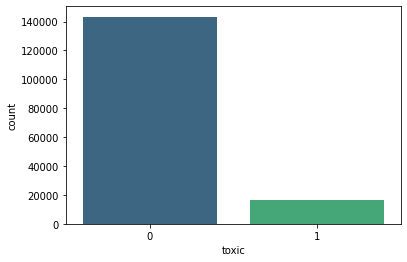

In [41]:
print(round(data['toxic'].value_counts(normalize=True)*100), "\n")
sns.countplot(x='toxic', data=data, palette="viridis");

По распределению целевой переменной можно увидеть, что значение "0" встречается значительно чаще, чем значение "1".

Разделим датасет на тренировочную, валидационную и обучающую выборки.

In [42]:
data_train, data_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.2)

Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():

In [43]:
features_train = count_tf_idf.fit_transform(data_train)

In [44]:
features_test = count_tf_idf.transform(data_test)

Данные подготовлены, перейдем к построению моделей.

## Обучение

### SGDClassifier

Построим модель с помощью стохастического градиентного спуска.

In [229]:
sgd_model = SGDClassifier()

In [230]:
%%time
sgd_model.fit(features_train, target_train)

CPU times: user 353 ms, sys: 92.5 ms, total: 445 ms
Wall time: 454 ms


SGDClassifier()

In [231]:
sgd_result = sgd_model.predict(features_test)

In [232]:
f1_sgd = f1_score(target_test, sgd_result)
print('F1 на тестовой выборке {:.3f}'.format(f1_sgd))

F1 на тестовой выборке 0.625


[[28640    46]
 [ 1739  1490]]


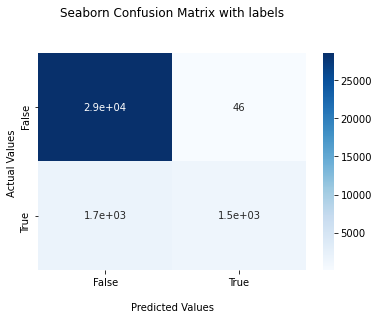

In [244]:
cf_matrix = confusion_matrix(target_test, sgd_result)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
print(cf_matrix)

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### Random Forest

In [235]:
rand_for = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')

In [236]:
rand_for.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [237]:
rand_for_result = clf.predict(features_test)
f1 = f1_score(target_test, rand_for_result)
print('F1 на тестовой выборке {:.3f}'.format(f1))

F1 на тестовой выборке 0.184


[[   51 28635]
 [    6  3223]]


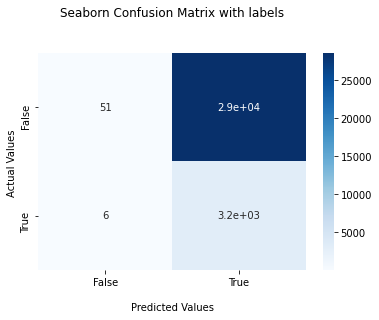

In [245]:
cf_matrix = confusion_matrix(target_test, rand_for_result)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
print(cf_matrix)

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### CatBoost

In [246]:
model_cat = CatBoostClassifier()

In [253]:
%%time
model_cat.fit(features_train, target_train);

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.081698
0:	learn: 0.6099196	total: 2.41s	remaining: 40m 11s
1:	learn: 0.5398483	total: 4.33s	remaining: 35m 58s
2:	learn: 0.4839670	total: 6.15s	remaining: 34m 5s
3:	learn: 0.4401225	total: 8.03s	remaining: 33m 20s
4:	learn: 0.4021657	total: 9.98s	remaining: 33m 5s
5:	learn: 0.3713207	total: 11.9s	remaining: 32m 45s
6:	learn: 0.3470433	total: 13.8s	remaining: 32m 31s
7:	learn: 0.3265991	total: 15.6s	remaining: 32m 20s
8:	learn: 0.3097151	total: 17.6s	remaining: 32m 22s
9:	learn: 0.2959587	total: 19.6s	remaining: 32m 15s
10:	learn: 0.2832324	total: 21.5s	remaining: 32m 13s
11:	learn: 0.2739045	total: 23.4s	remaining: 32m 6s
12:	learn: 0.2663480	total: 25.3s	remaining: 31m 57s
13:	learn: 0.2593894	total: 27.2s	remaining: 31m 52s
14:	learn: 0.2535985	total: 29s	remaining: 31m 44s
15:	learn: 0.2487299	total: 30.9s	remaining: 31m 41s
16:	learn: 0.2445319	total: 32.9s	remaining: 31m 40s
17:	learn: 0.2400694	total: 34.7s	remaining: 31m 35s
18:	learn: 0.2367563	total: 36.

In [254]:
cat_result = model_cat.predict(features_test)
f1_test = f1_score(target_test, cat_result)
print('F1 на тестовой выборке {:.3f}'.format(f1_test))

F1 на тестовой выборке 0.744


[[28472   214]
 [ 1188  2041]]


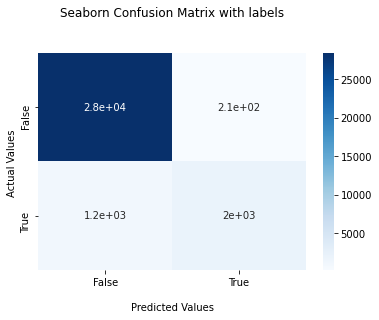

In [255]:
cf_matrix = confusion_matrix(target_test, cat_result)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
print(cf_matrix)

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

Наибольшее значение f1 было получено при использовании модели CatBoost, но обучение длилось достаточно долго - около 29 минут. Модель, полученная с помощью SGDClassifier оказалась быстрее, чем CatBoost - обучение заняло менее 1 секунды. При этом SGDClassifier оказался точнее, чем RandomForest.<br>
Подберем оптимальные гиперпараметры SGDClassifier для получения f1 выше 0.75.

### Подбор гиперпараметров

In [56]:
pipeline = Pipeline(
    [
        ("tfidf", count_tf_idf),
        ("clf", SGDClassifier())
    ]
)

In [60]:
params = [ {'clf__loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
             'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 
            'clf__random_state' : [12345],
            'clf__alpha' : list(np.arange(1.1, 1.6, 0.1))}]

In [61]:
model = GridSearchCV(pipeline, param_grid = params, cv = 4, verbose=True,
                            n_jobs=-1)

In [63]:
%%time
model = model.fit(data_train, target_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
CPU times: user 17min 24s, sys: 13.8 s, total: 17min 38s
Wall time: 17min 39s


In [64]:
model.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('clf',
                 SGDClassifier(alpha=1.1, loss='perceptron',
                               random_state=12345))])

In [67]:
model_result = model.predict(data_test)
f1_model = f1_score(target_test, model_result)
print('F1 на тестовой выборке {:.3f}'.format(f1_model))

F1 на тестовой выборке 0.767


[[27967   674]
 [  820  2454]]


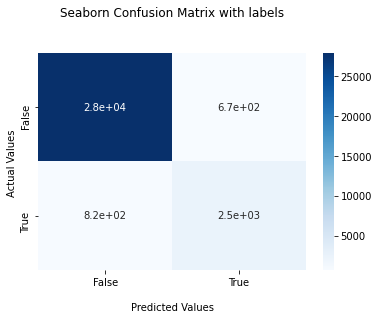

In [68]:
cf_matrix = confusion_matrix(target_test, model_result)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
print(cf_matrix)

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## Выводы

В результате работы была выполнена предобработка данных: лемматизация, очистка от символов и стоп-слов, а также генерация признаков.<br>
На полученном датасете были построены модели SGDClassifier, RandomForest, CatBoost. Обучение CatBoost занимает много времени, а RandomForest недостаточно точен, поэтому был выбран SGDClassifier.<br> В итоге была получена модель для определения токсичных комментариев с помощью метода SGDClassifier, f1 полученной модели  - 0,767.